In [12]:
# import subprocess

# packages = ['geemap', 'geopandas',
#             'shapely', 'requests', 
#             'osgeo', 'rasterio', 'numpy',
#             'sklearn', 'fiona', 'pyproj',
#             'matplotlib', 'pandas',
#             'seaborn','geocube', 'os']

# for package in packages:
#     try:
#         __import__(package)
#     except ImportError:
#         subprocess.check_call(['pip', 'install', package])

import neccessary libaries

In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import json
import rasterio as rio
import shapely
import fiona
import warnings

warnings.filterwarnings('ignore')

In [14]:
# load the boundary shapefile for Area of Intrest (AOI)
study_area = gpd.read_file('data/tocantins.shp')
study_area.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,33,BRA,Brazil,27,TO,Estado,State,None,None,"POLYGON ((-48.35310 -5.17391, -48.32085 -5.201..."


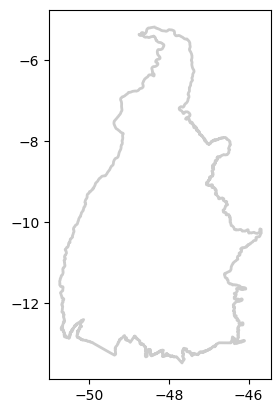

In [15]:
study_area.plot( linewidth=2, color='white', edgecolor='0.8');

The independent variables that will be use in building this model are in raster format, they will be extracted from google earth engine and downloaded uisng geemap and ee API.

In [16]:
# import google eath enigne libary for python
import io
import geemap
import ee

In [17]:
# Autheticate the Google earth engine ee login
key_file = './keys/data-enginerring-zoomcamp-b8719aa4a43e.json'
email = 'farm-watch-project@data-enginerring-zoomcamp.iam.gserviceaccount.com'
try:
    credentials = ee.ServiceAccountCredentials(email=email, key_file=key_file)
    ee.Initialize(credentials)
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### Data Extraction and Transformation

Define ee boundary

In [18]:
# convert the boundary shapefile to ESPG 4326
boundary = study_area

# define a helper function to put the geodataframe in the right format for constructing an ee object
def shp_to_ee_fmt(geodf):
    data = json.loads(geodf.to_json())
    return data['features'][0]['geometry']['coordinates']

# create the ee object
feature_cls = ee.Geometry.MultiPolygon(shp_to_ee_fmt(boundary))

Generate Slope, DEM , and TWI

In [19]:
#load SRTM data from google earth engine
srtm = ee.Image('CGIAR/SRTM90_V4')

# Generate individual raster data
elevation = srtm.select('elevation')
slope = ee.Terrain.slope(elevation)


# Generate TWI
def create_twi(image,slope):
    # get the cell size
    cell_size = image.projection().nominalScale().getInfo();
    
    # Calculate the slope in radians
    slopeRad = (slope.multiply(1.570756)).divide(90);
    
    #  Calculate slope in tan by removing zero value
    tan_slope = slopeRad.gt(0).multiply(slopeRad.tan()).where(slopeRad.gt(0), 0.001);
    
    #  Calculate Upslope
    up_slope = flowAccumulation.add(1).multiply(cell_size);
    
    # Calculate the TWI
    twi = up_slope.divide(tan_slope).log()
    return twi

# Load the flow accumulation dataset
dataset = ee.Image('WWF/HydroSHEDS/15ACC')
flowAccumulation = dataset.select('b1').clip(feature_cls)
twi_image = create_twi(flowAccumulation,slope)

Generate LULC

In [20]:
# load ESA 2020 World wide 10m land cover  data form google earth
collection = (
    ee.ImageCollection('ESA/WorldCover/v200')
    .filterBounds(feature_cls)
)

landcover = collection.first()

# collection.aggregate_array('system:index').getInfo()

Generate NDVI, NDMI and BSI

In [21]:
# select Landsat 8 collection for the spectal indices
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA") \
    .filterBounds(feature_cls) \
    .filterDate('2021-01-01', '2022-12-31') \
    .sort('CLOUD_COVER') \
    .median()


# Calculate NDVI
ndvi = l8.normalizedDifference(['B5', 'B4']).rename('NDVI')
                               
# # Calculate NDMI
# ndmi = l8.normalizedDifference(['B5', 'B6']).rename('NDMI')

# # Calculate BSI
# bsi = l8.expression(
#     '((SWIR2 + RED) - (SWIR1 + NIR)) / ((SWIR2 + RED) + (SWIR1 + NIR))',
#     {
#         'SWIR1': l8.select('B6'),
#         'SWIR2': l8.select('B6'),
#         'NIR': l8.select('B5'),
#         'RED': l8.select('B4')
#     }
# ).rename('BSI')

Generate LST and SMI

In [46]:
# Function to calculate LST uisng tier 2 correct images
def calculate_LST(tier2_image, region):
    LST = tier2_image.expression(
        '(ST_B10 * 0.00341802 + 149.0) - 273.15',  # convert to Celsius
        {'ST_B10': tier2_image.select('ST_B10')}
    ).rename('Landsat_LST')
    return LST

# Function to calculate Soil Moisture Index (SMI)
def calculate_SMI(LST, lst_min, lst_max):
    # Calculate Soil Moisture Index (SMI)
    print(lst_max-lst_min)
    SMI = LST.subtract(lst_min).divide(lst_max-lst_min).rename('SMI')
    return SMI

# Example of getting the TOA image
sr_image = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")\
    .filterBounds(feature_cls) \
    .filterDate('2021-01-01', '2023-12-31') \
    .select('ST_B10')\
    .sort('CLOUD_COVER').median() \

# Calculate LST
lst_image = calculate_LST(sr_image,feature_cls)
type(LST_image)

# Define minimum and maximum values for LST
lst_min = lst_image.reduceRegion(reducer=ee.Reducer.min(), geometry=feature_cls, scale=1000,maxPixels=28397913).get('Landsat_LST').getInfo()
lst_max = lst_image.reduceRegion(reducer=ee.Reducer.max(), geometry=feature_cls, scale=1000,maxPixels=28397913).get('Landsat_LST').getInfo()

print(lst_min)
print(lst_max)
# Calculate SMI
smi_image = calculate_SMI(lst_image, lst_min, lst_max)

-83.93357667999999
50.879968159999976
134.81354483999996


In [32]:
print(smi_image.getInfo())

{'type': 'Image', 'bands': [{'id': 'SMI', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2983114446529081, 'max': 1.3632422290958883}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


Generate Rainfall data

In [33]:
# Define date range
start_date = '2012-01-01'
end_date = '2022-12-31'

# Load CHIRP precipitation data
rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterBounds(feature_cls) \
    .filterDate(start_date, end_date) \
    .select('precipitation') \
    .sum()

# # Load average temperature data
# temp = ee.ImageCollection('NOAA/CFSV2/FOR6H') \
#     .filterBounds(feature_cls) \
#     .filterDate(start_date, end_date) \
#     .select('Temperature_height_above_ground') \
#     .mean()

Soil Texture

In [41]:
# Load openland global soil texture data
soil_texture = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")\

# b30 42 110 10 Soil pH in H2O at 30 cm depth
texture_depth_30cm = soil_texture.select('b30').clip(feature_cls)

Soil pH

In [62]:
# Load openland global soil ph data
soil_ph = ee.Image("OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02") \

# Soil pH in H2O at 30 cm depth and scale itdown by 10
ph_depth_30cm = soil_ph.select('b30').clip(feature_cls).divide(10)

Get Global SOC datasets

In [63]:
# # Global SOC soc dataset
# soc= ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")\
#         .select('b0')

# # refactor the soc data
# soc = soc.multiply(0.005)

Clip all images to features

In [64]:
# clip all the images load to the study area
# elevation data model image 30m
elevation_clip  = elevation.clip(feature_cls)
# slope data generated from elevation data
slope_clip = slope.clip(feature_cls)
# landcover image
landcover_clip = landcover.clip(feature_cls)
#rainfall data fro chirps datasets
rainfall_clip = rainfall.clip(feature_cls)
# vegetation index
ndvi_clip = ndvi.clip(feature_cls)
# topographic wetness index
twi_clip = twi_image.clip(feature_cls)
# soil ph
soil_ph = ph_depth_30cm.clip(feature_cls)
# soil texture
soil_texture = texture_depth_30cm.clip(feature_cls)
# land surface temperature
lst_clip = lst_image.clip(feature_cls)
# soil moisture index
smi_clip = smi_image.clip(feature_cls)


# bsi_clip = bsi.clip(feature_cls)
# ndmi_clip = ndmi.clip(feature_cls)
# temp_clip = temp.clip(feature_cls)
# soc_clip = soc.clip(feature_cls)

Set Visualization Parameters

In [65]:
# visualization parameters
elevation_viz = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}

slope_viz = {
    'min': 0,
    'max': 60,
    'palette': ['brown', 'yellow', 'green']
}

landcover_viz = {
  'min': 0,
  'max': 100,
  'palette': [
      'FC6D26', 'FCAF17', 'E8EB45', '34B334', '4C7EAF',
      'B05AFF', 'A56F37', '914D25', 'BFC0C3', 'FFFFFF',
  ]
}

rainfall_viz = {
    'min': 0,
    'max': 300000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}


temp_viz = {
    'min': 0,
    'max': 50,
    'palette': ['#0000ff', '#800080', '#00ffff', '#008000', '#ffff00', '#ff0000']
}

ndvi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}



soil_texture_viz = {
    'min': 1,
    'max': 12,
    'palette': ['#ff0000', ' #ffff00', '#008000']
}

twi_viz = {
    'min': 10,
    'max': 30,
    'palette': ['#ff0000', ' #ffff00', '#008000']
}





# bsi_viz = {
#     'min': -1,
#     'max': 1,
#     'palette': ['red', 'yellow', 'green']
# }


# soc_viz = {
#   'min': 0.0,
#   'max': 120.0,
#   'palette': [
#     "ffffa0","f7fcb9","d9f0a3","addd8e","78c679","41ab5d",
#     "238443","005b29","004b29","012b13","00120b",
#   ]
# }

Add Data to Map layer to visualize all data

In [66]:
# instatiate Map()
Map = geemap.Map()

# add the boundary layer to the viz
Map.addLayer(feature_cls,{},"Study Area")

# Add all image layer to a basemap
Map.addLayer(elevation_clip, elevation_viz, 'Elevation')
Map.addLayer(slope_clip, slope_viz, 'Slope')
Map.addLayer(landcover_clip, landcover_viz, 'Landcover')
Map.addLayer(rainfall_clip, rainfall_viz, 'Rainfall')
Map.addLayer(ndvi_clip, ndvi_viz, 'NDVI')
Map.addLayer(lst_clip, temp_viz, 'LST')
Map.addLayer(smi_clip, ndvi_viz, 'SMI')
Map.addLayer(twi_clip, twi_viz, 'TWI')
Map.addLayer(soil_ph, soil_texture_viz, 'PH')
Map.addLayer(soil_texture, soil_texture_viz , 'Texture')


# set map center object
Map.centerObject(feature_cls, 5)

# call the geemap Map object
Map

# Map.addLayer(temp_clip, temp_viz, 'Temperature')
# Map.addLayer(bsi_clip, bsi_viz, 'BSI')
# Map.addLayer(soc_clip, soc_viz,'soc organic carbon content in x 5 g / kg')

Map(center=[-10.14095118527972, -48.32883664541774], controls=(WidgetControl(options=['position', 'transparent…

Save imageries locally so that it can be used to create maps

In [69]:
from utils.export_ee_image import export_ee_image_list

raster_list = [
    elevation_clip,slope_clip, landcover_clip,
    rainfall_clip, lst_clip,
    ndvi_clip,twi_clip,smi_clip,soil_ph,soil_texture
]

output_list = [
    "elevation","slope", "landcover",
    "rainfall", "lst",
    "ndvi","twi","smi","soil_ph","soil_texture"
]

# checking if the directory 
if not os.path.exists("output_images"):      
    # if the directory is not present, then create it. 
    os.makedirs("output_images") 
    
out_folder='output_images'
scale = 5000
region=feature_cls

export_ee_image_list(raster_list,output_list,
                      out_folder,scale,feature_cls)

Exporting elevation...
output_images\elevation.tif already exists.
Exporting slope...
output_images\slope.tif already exists.
Exporting landcover...
output_images\landcover.tif already exists.
Exporting rainfall...
output_images\rainfall.tif already exists.
Exporting lst...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Admin\Desktop\Dr Chu\tocantins-soc-prediction\output_images\lst.tif
lst downloaded successfully to output_images\lst.tif.
Exporting ndvi...
output_images\ndvi.tif already exists.
Exporting twi...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Admin\Desktop\Dr Chu\tocantins-soc-prediction\output_images\twi.tif
twi downloaded successfully to output_images\twi.tif.
Exporting smi...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Admin\Desktop\Dr Chu\tocantins-soc-prediction\output_images\smi.tif
smi downloaded successfully to output_images\smi.tif.
Exporting soil_ph...
Generating URL ...
Please wait ...
Data downloaded to C:\U

Geneare random smapling points within the aoi

In [104]:
# load sampling point data collected on the field
training_dataset = gpd.read_file('data/training_dataset_soc.csv')

# convert csv file to geopoint
point_data = gpd.GeoDataFrame(
    training_dataset, geometry=gpd.points_from_xy(training_dataset.longitude,training_dataset.latitude), crs="EPSG:4326")

point_data.head()

,SOC_gkg,latitude,longitude,geometry
0,8.440308059039999,-10.160223133000001,-49.850637085999999,POINT (-49.85064 -10.16022)
1,2.765353636110000,-11.789786957000000,-48.614034791000002,POINT (-48.61403 -11.78979)
2,6.084392265510000,-9.709371274000000,-49.203478406999999,POINT (-49.20348 -9.70937)
3,8.027136231729999,-9.706367021000000,-48.544403447999997,POINT (-48.54440 -9.70637)
4,9.672289075060000,-13.038174777000000,-48.543180286000002,POINT (-48.54318 -13.03817)


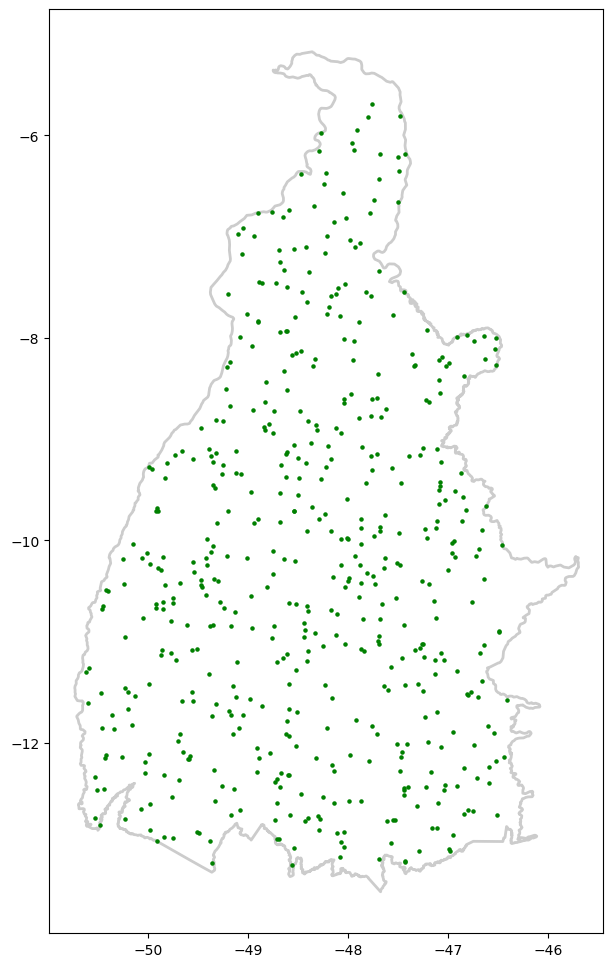

In [105]:
# plot the random points to see the distribution
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
ax = boundary.plot(ax=ax, linewidth=2, color='white', edgecolor='0.8')
point_data.plot(ax=ax, markersize=5, color='green');

#### Extract the dependent raster varibale data to the sampling points 

In [ ]:
from utils.extract_raster_values import get_value_to_point
import rasterio as rio

# use raterio to load all the data
def open_image(image_path:str):
    image =  rio.open(image_path)
    return image
     
elevation = open_image('output_images/elevation.tif') 
slope = open_image('output_images/slope.tif') 
landcover = open_image('output_images/landcover.tif') 
rainfall = open_image('output_images/rainfall.tif')
lst = open_image('output_images/lst.tif')
ndvi = open_image('output_images/ndvi.tif') 
twi = open_image('output_images/twi.tif')
smi = open_image('output_images/smi.tif')
soil_ph = open_image('output_images/soil_ph.tif')
soil_texture = open_image('output_images/soil_texture.tif')

raster_list = [elevation, slope, landcover,rainfall,lst, ndvi,twi,smi, soil_ph,soil_texture]

point_data = get_value_to_point(point_data, raster_list) 

# drop geomerty field
point_data.drop(columns='geometry',inplace=True)

# Rename Fields
cols = ['latitude','longitude','SOC_gkg','elevation', 'slope',
         'landcover', 'rainfall', 'lst',
         'ndvi','twi','smi', 'soil_ph','soil_texture']
point_data.columns=cols

In [ ]:
# read the dataset to view the addeded columns
point_data.head()

,latitude,longitude,SOC_gkg,elevation,slope,landcover,rainfall,lst,ndvi,twi,smi,soil_ph,soil_texture
0,8.440308059039999,-10.160223133000001,-49.850637085999999,185,0.270516,10,19218.950924,31.576700,0.561436,16.448473,0.856815,5.2,6
1,2.765353636110000,-11.789786957000000,-48.614034791000002,232,0.159543,80,17822.625546,28.394524,0.560993,15.244501,0.833211,5.3,6
2,6.084392265510000,-9.709371274000000,-49.203478406999999,226,1.069493,30,20349.224003,33.068666,0.584067,18.116180,0.867882,5.2,6
3,8.027136231729999,-9.706367021000000,-48.544403447999997,253,0.403950,30,19063.720844,34.493980,0.508245,16.091798,0.878454,5.2,6
4,9.672289075060000,-13.038174777000000,-48.543180286000002,459,3.546990,10,15968.951756,34.223957,0.465976,15.244501,0.876451,5.5,6


Extract Longitude and Latitude and Svae file as csv

In [110]:
# # extract lat and long
# point_data['longitude'] = point_data.geometry.x
# point_data['latitude'] = point_data.geometry.y

# # drop geomerty field
# point_data.drop(columns='geometry',inplace=True)

# # show
# point_data

In [111]:
# Save data to csv
point_data.to_csv('training_dataset.csv',index=False)